In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# model = MyModel().to(device)

In [3]:
diagnostics={"NORM":['NORM','CSD'],
             "STTC":['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ],
             "MI":['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL'],
             "HYP":['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP'],
             "CD":['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB', '2AVB'],
             "OTHER":['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC']
            }

In [4]:
db_path="../../dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [5]:
print(ecg_data)

       ecg_id  patient_id    age  sex  height  weight  nurse  site  \
0           1     15709.0   56.0    1     NaN    63.0    2.0   0.0   
1           2     13243.0   19.0    0     NaN    70.0    2.0   0.0   
2           3     20372.0   37.0    1     NaN    69.0    2.0   0.0   
3           4     17014.0   24.0    0     NaN    82.0    2.0   0.0   
4           5     17448.0   19.0    1     NaN    70.0    2.0   0.0   
...       ...         ...    ...  ...     ...     ...    ...   ...   
21794   21833     17180.0   67.0    1     NaN     NaN    1.0   2.0   
21795   21834     20703.0  300.0    0     NaN     NaN    1.0   2.0   
21796   21835     19311.0   59.0    1     NaN     NaN    1.0   2.0   
21797   21836      8873.0   64.0    1     NaN     NaN    1.0   2.0   
21798   21837     11744.0   68.0    0     NaN     NaN    1.0   2.0   

           device       recording_date  ... validated_by_human  \
0       CS-12   E  1984-11-09 09:17:34  ...               True   
1       CS-12   E  1984-11-

In [6]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21799 entries, 0 to 21798
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21799 non-null  int64  
 1   patient_id                    21799 non-null  float64
 2   age                           21799 non-null  float64
 3   sex                           21799 non-null  int64  
 4   height                        6974 non-null   float64
 5   weight                        9421 non-null   float64
 6   nurse                         20326 non-null  float64
 7   site                          21782 non-null  float64
 8   device                        21799 non-null  object 
 9   recording_date                21799 non-null  object 
 10  report                        21799 non-null  object 
 11  scp_codes                     21799 non-null  object 
 12  heart_axis                    13331 non-null  object 
 13  i

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,1,0,0,0,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,1,0,0,0,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,1,0,0,0,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,1,0,0,0,0


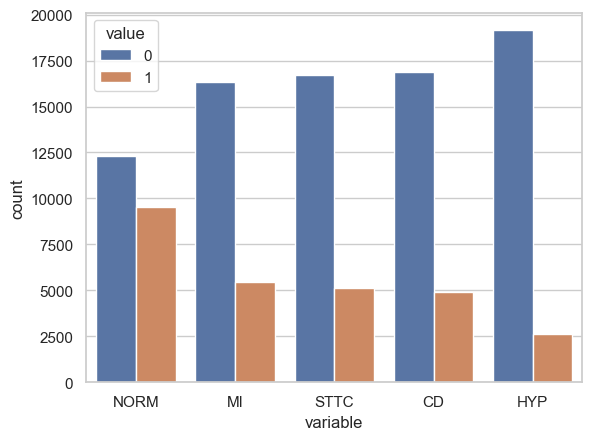

In [7]:
from ver5_journal.common.data.create_final_data import create_final_data

final_data = create_final_data()
final_data.head()

In [8]:
print(final_data['NORM'].value_counts())
print(final_data['STTC'].value_counts())
print(final_data['MI'].value_counts())
print(final_data['HYP'].value_counts())
print(final_data['CD'].value_counts())

NORM
0    12285
1     9514
Name: count, dtype: int64
STTC
0    16691
1     5108
Name: count, dtype: int64
MI
0    16330
1     5469
Name: count, dtype: int64
HYP
0    19150
1     2649
Name: count, dtype: int64
CD
0    16901
1     4898
Name: count, dtype: int64


In [9]:
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

print(f'NORM: {ECG_train[ECG_train['NORM'] == 1].shape[0]}')
print(f'STTC: {ECG_train[ECG_train['STTC'] == 1].shape[0]}')
print(f'MI: {ECG_train[ECG_train['MI'] == 1].shape[0]}')
print(f'HYP: {ECG_train[ECG_train['HYP'] == 1].shape[0]}')
print(f'CD: {ECG_train[ECG_train['CD'] == 1].shape[0]}')


NORM: 7596
STTC: 4087
MI: 4379
HYP: 2119
CD: 3907


In [13]:
from ver5_journal.common.data.ECG_Data import ECG_Data

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)
first_batch, label = next(iter(train_loader))

data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000

In [10]:
from ver5_journal.common.data.ECG_Data import ECG_Data

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

data, label = train_dataset[0] 

first_batch, label = next(iter(train_loader))

data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000)
label : (5,)
data_new : (12, 1000

In [11]:
from ver5_journal.common.data.ECG_Data import ECG_Data

# ECG_train=ECG_train.reset_index()
# ECG_test=ECG_test.reset_index()

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

first_batch, label = next(iter(train_loader))

print(f"Batch shape: {first_batch.shape}")



"""
for i in range(12):
    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')
"""

Batch shape: torch.Size([64, 12, 1000])


"\nfor i in range(12):\n    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')\n"

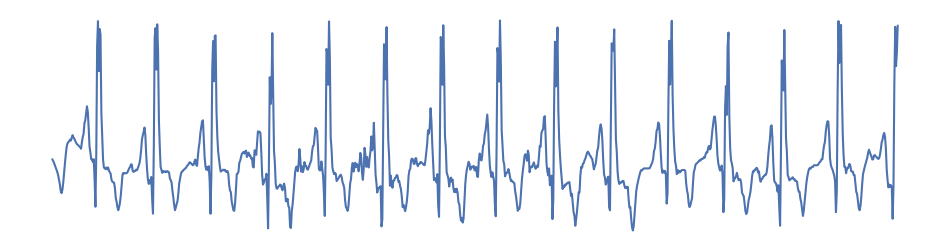

In [12]:
sample = first_batch[0]
plt.figure(figsize=(12,3))
plt.axis(False)
plt.plot(sample[1,:])

In [13]:
len(train_loader), len(val_loader), len(test_loader)

(273, 35, 35)